In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from matplotlib import pyplot as plt
import os
import torch

In [2]:
path = "/data/codes/prep_ps_pykaldi/prep_data/info_qt_10_trainset.jsonl"
with open(path, "r", encoding="utf-8") as f:
    lines = f.readlines()
    lines = [json.loads(line.strip()) for line in lines]

df = pd.DataFrame(lines)
df.head(2)

,uid,id,qid,text,arpas,phone_scores,trans
0,60423.0,1403449,10274,CHILLY,"[CH, IH1, L, IY0]","[0, 90, 98, 88]","[SH, IH, L, IY]"
1,46424.0,2632422,10274,CHILLY,"[CH, IH1, L, IY0]","[0, 24, 95, 99]","[AY, UW, L, IY]"


In [277]:
# import shutil

# def copy_audio(id):
#     audio_dir = "/data/audio_data/prep_submission_audio/10"
#     out_dir = "/data/codes/prep_ps_pykaldi/prep_data/wav"

#     wav_path = f'{audio_dir}/{id}.wav'
#     shutil.copy(wav_path, out_dir)

# df.id.apply(copy_audio)

0         None
1         None
2         None
3         None
4         None
          ... 
130953    None
130954    None
130955    None
130956    None
130957    None
Name: id, Length: 130958, dtype: object

In [274]:
# df.sample(30000)[["id", "text"]].to_csv("/data/codes/prep_ps_pykaldi/prep_data/metadata.csv", sep="|", index=None, header=None)

In [279]:
new_df = []
for name, group in df.groupby("text"):
    if group.shape[0] > 300:
        new_df.append(group.sample(300))
    else:
        new_df.append(group)

new_df = pd.concat(new_df)
print(new_df.shape)

(79828, 7)


In [284]:
new_df.head()

,uid,id,qid,text,arpas,phone_scores,trans
78383,137483.0,3380849,26547,A JAM BREAD,"[AH0, JH, AE1, M, B, R, EH1, D]","[20, 87, 96, 90, 0, 99, 91, 67]","[SCHWA, JH, AE, M, B, R, EH, T]"
78243,161414.0,3764582,26547,A JAM BREAD,"[AH0, JH, AE1, M, B, R, EH1, D]","[22, 28, 0, 86, 30, 99, 91, 16]","[SCHWA, CH, EY, M, B, R, EH, K]"
78347,202127.0,4638326,26547,A JAM BREAD,"[AH0, JH, AE1, M, B, R, EH1, D]","[21, 0, 87, 99, 95, 100, 100, 12]","[SCHWA, SH, AE, M, B, R, EH, T]"
78140,25322.0,3259658,26547,A JAM BREAD,"[AH0, JH, AE1, M, B, R, EH1, D]","[93, 87, 0, 100, 100, 100, 100, 95]","[SCHWA, JH, EY, M, B, R, EH, D]"
78476,231539.0,5477355,26547,A JAM BREAD,"[AH0, JH, AE1, M, B, R, EH1, D]","[18, 9, 98, 97, 86, 100, 91, 0]","[SCHWA, Z, AE, M, B, R, EH, CH]"


In [340]:
def filter(phone_scores, score_threshold=80, rate_threshold=0.4):
    phone_scores = np.array(phone_scores)

    low_score = phone_scores < score_threshold
    # low_score_1 = phone_scores > 0
    # low_score = low_score * low_score_1
    high_score = phone_scores >= score_threshold

    rate = low_score.sum() / len(phone_scores)

    return rate > rate_threshold

temp = new_df.phone_scores.apply(filter)
filted_df = new_df[temp==True].reset_index()
print(new_df.shape)
print(filted_df.shape)
print(new_df[temp==False].shape)

(79828, 7)
(18039, 8)
(61789, 7)


<Axes: >

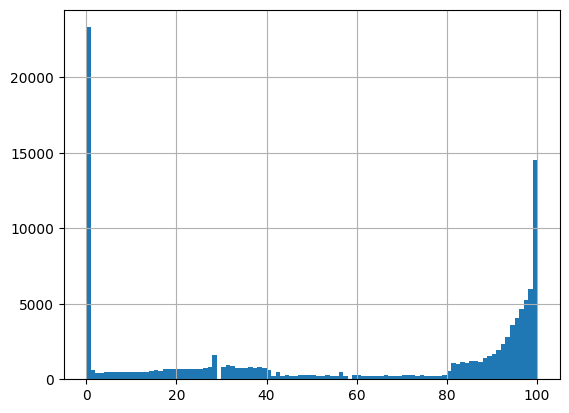

In [341]:
filted_df.phone_scores.explode().hist(bins=100)

In [291]:
import random
from tqdm import tqdm

aug_data = []
threshold_1 = 40
threshold_2 = 60
threshold_3 = 85
threshold_4 = 90
max_aug_per_sample = 6
for index in tqdm(filted_df.index):
    phone_scores = filted_df["phone_scores"][index]

    for i in range(random.randint(3, max_aug_per_sample)):
        aug_phone_scores = []
        aug_sample = filted_df.iloc[index].to_dict()
        for score in phone_scores:
            if score >= threshold_4:
                random_score = random.randint(-5, 0)
            elif score < threshold_4 and score >= threshold_3:
                random_score = random.randint(-10, -5)
            elif score < threshold_3 and score >= threshold_2:
                random_score = random.randint(-15, -5)
            elif score < threshold_2 and score >= threshold_1:
                random_score = random.randint(0, 15)
            elif score < threshold_1:
                random_score = random.randint(-10, 25)
            else:
                raise Exception()

            aug_score = score + random_score

            if aug_score < 0:
                aug_score = random.randint(0, 5)
            elif aug_score > 100:
                aug_score = 100
            
            aug_phone_scores.append(aug_score)
        aug_sample["phone_scores"] = aug_phone_scores

        aug_data.append(aug_sample)
    aug_data.append(filted_df.iloc[index].to_dict())
aug_data = pd.DataFrame(aug_data)
print(aug_data.shape)

  0%|          | 0/18039 [00:00<?, ?it/s]

100%|██████████| 18039/18039 [00:02<00:00, 6323.28it/s]

(98997, 8)


<Axes: >

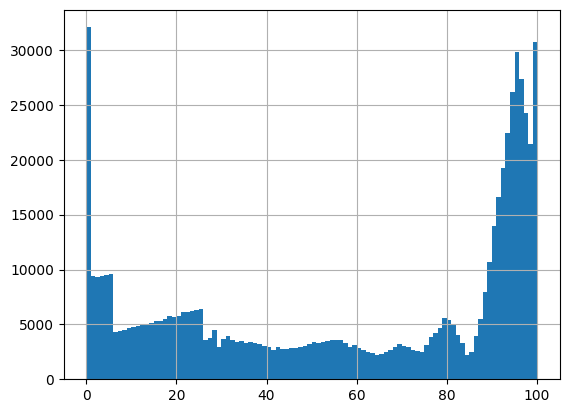

In [296]:
aug_data.phone_scores.explode().hist(bins=100)

In [292]:
merged = pd.concat([new_df[temp==False], aug_data])
merged.reset_index(inplace=True)
print(merged.shape)

(160786, 9)


In [293]:
temp = merged[["uid", "id", "qid", "text", "arpas", "phone_scores", "trans"]]
data = []
for index in temp.index:
    _dict = temp.iloc[index].to_dict()

    json_obj = json.dumps(_dict)
    data.append(json_obj)

In [261]:
path = "/data/codes/prep_ps_pykaldi/prep_data/aug_info_qt_10_trainset_sub.jsonl"
with open(path, "w", encoding="utf-8") as f:
    for line in data:
        f.write(line + "\n")

<Axes: >

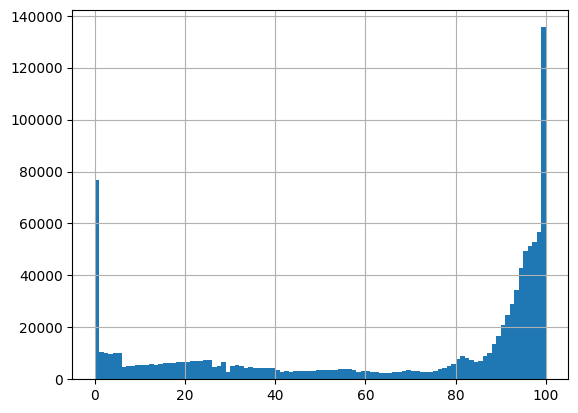

In [294]:
merged.phone_scores.explode().hist(bins=100)

<Axes: >

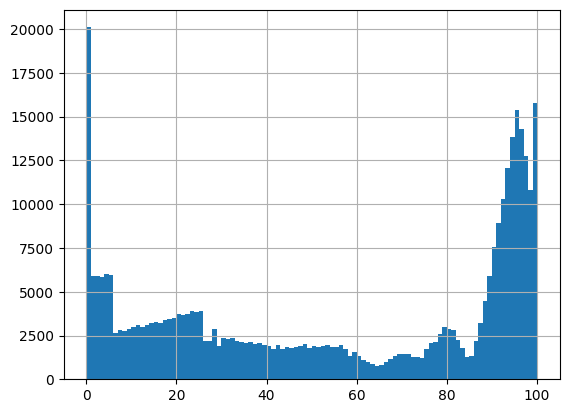

In [266]:
aug_data.phone_scores.explode().hist(bins=100)

<Axes: >

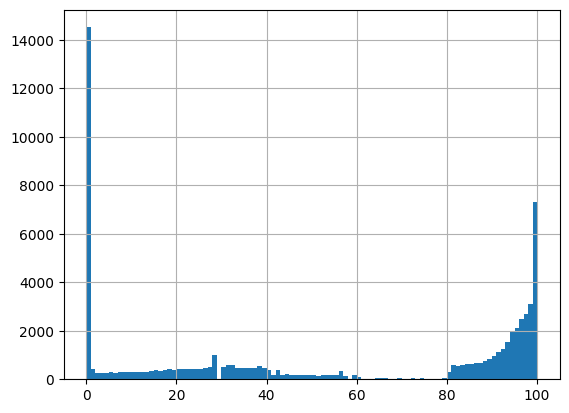

In [267]:
filted_df.phone_scores.explode().hist(bins=100)

<Axes: >

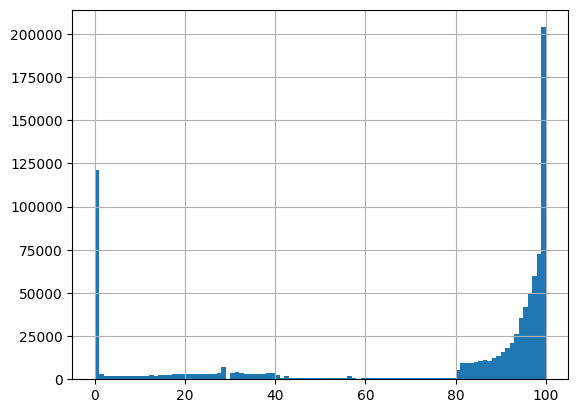

In [247]:
# visualize phone_score
df.phone_scores.explode().hist(bins=100)

<Axes: >

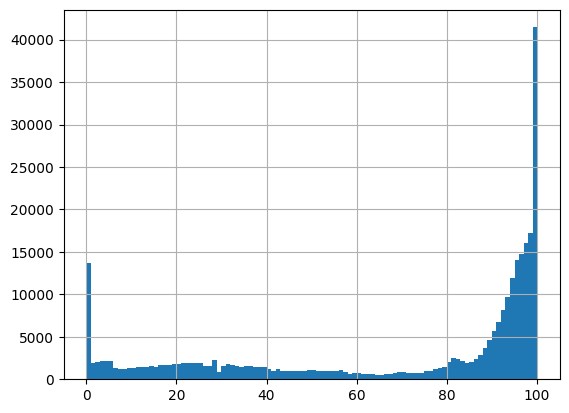

In [173]:
temp = pd.concat([df, aug_data])
temp.phone_scores.explode().hist(bins=100)